<a href="https://colab.research.google.com/github/arminarj/DGCCA-pytorch/blob/master/DGCCA_loss_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn


In [0]:
def GCCA_loss(H1, H2):
    r = 1e-4
    eps = 1e-8

    # H1, H2, H3 = H1.t(), H2.t(), H3.t()

    # print(f'H1 shape ( N X feature) : {H1.shape}')

    assert torch.isnan(H1).sum().item() == 0 
    assert torch.isnan(H2).sum().item() == 0
    # assert torch.isnan(H3).sum().item() == 0

    o1 = H1.size(0)  # N
    o2 = H2.size(0)
    m = H1.size(1)   # out_dim

    top_k = 10

    H1bar = H1 - H1.mean(dim=1).repeat(m, 1).view(-1, m)
    H2bar = H2 - H2.mean(dim=1).repeat(m, 1).view(-1, m)
    assert torch.isnan(H1bar).sum().item() == 0
    assert torch.isnan(H2bar).sum().item() == 0

    A1, S1, B1 = H1bar.svd(some=True, compute_uv=True)
    A2, S2, B2 = H2bar.svd(some=True, compute_uv=True)

    A1, A2 = A1[:, :top_k], A2[:, :top_k]

    assert torch.isnan(A1).sum().item() == 0
    assert torch.isnan(A2).sum().item() == 0

    S_thin_1, S_thin_2 = S1[:top_k], S2[:top_k]


    S2_inv_1 = 1. / (torch.mul( S_thin_1, S_thin_1 ) + eps)
    S2_inv_2 = 1. / (torch.mul( S_thin_2, S_thin_2 ) + eps)

    assert torch.isnan(S2_inv_1).sum().item() == 0
    assert torch.isnan(S2_inv_2).sum().item() == 0

    T2_1 = torch.mul( torch.mul( S_thin_1, S2_inv_1 ), S_thin_1 )
    T2_2 = torch.mul( torch.mul( S_thin_2, S2_inv_2 ), S_thin_2 )

    assert torch.isnan(T2_1).sum().item() == 0
    assert torch.isnan(T2_2).sum().item() == 0

    T2_1 = torch.where(T2_1>eps, T2_1, (torch.ones(T2_1.shape)*eps).to(H1.device).double())
    T2_2 = torch.where(T2_2>eps, T2_2, (torch.ones(T2_2.shape)*eps).to(H2.device).double())


    T_1 = torch.diag(torch.sqrt(T2_1))
    T_2 = torch.diag(torch.sqrt(T2_2))

    assert torch.isnan(T_1).sum().item() == 0
    assert torch.isnan(T_2).sum().item() == 0

    T_unnorm_1 = torch.diag( S_thin_1 + eps )
    T_unnorm_2 = torch.diag( S_thin_2 + eps )

    assert torch.isnan(T_unnorm_1).sum().item() == 0
    assert torch.isnan(T_unnorm_2).sum().item() == 0

    AT_1 = torch.mm(A1, T_1)
    AT_2 = torch.mm(A2, T_2)

    M_tilde = torch.cat([AT_1, AT_2], dim=1)

    # print(f'M_tilde shape : {M_tilde.shape}')

    assert torch.isnan(M_tilde).sum().item() == 0

    Q, R = M_tilde.qr()

    assert torch.isnan(R).sum().item() == 0
    assert torch.isnan(Q).sum().item() == 0

    U, lbda, _ = R.svd(some=False, compute_uv=True)

    assert torch.isnan(U).sum().item() == 0
    assert torch.isnan(lbda).sum().item() == 0

    G = Q.mm(U[:,:top_k])
    assert torch.isnan(G).sum().item() == 0


    U = [] # Mapping from views to latent space

    # Get mapping to shared space
    views = [H1, H2]
    F = [o1, o2] # features per view
    for idx, (f, view) in enumerate(zip(F, views)):
        _, R = torch.qr(view)
        Cjj_inv = torch.inverse( (R.T.mm(R) + eps * torch.eye( view.shape[1], device=view.device)) )
        assert torch.isnan(Cjj_inv).sum().item() == 0
        pinv = Cjj_inv.mm( view.T)
            
        U.append(pinv.mm( G ))

    U1, U2  = U[0], U[1]
    _, S, _ = M_tilde.svd(some=True)

    assert torch.isnan(S).sum().item() == 0
    use_all_singular_values = False
    if not use_all_singular_values:
        S = S.topk(top_k)[0]
    corr = torch.sum(S )
    assert torch.isnan(corr).item() == 0
    # loss = 14.1421-corr
    loss = - corr
    return loss

In [0]:
def GCCA_loss(H_list):

    r = 1e-4
    eps = 1e-8

    # H1, H2, H3 = H1.t(), H2.t(), H3.t()

    # print(f'H1 shape ( N X feature) : {H1.shape}')

    # assert torch.isnan(H1).sum().item() == 0 
    # assert torch.isnan(H2).sum().item() == 0
    # assert torch.isnan(H3).sum().item() == 0

    # o1 = H1.size(0)  # N
    # o2 = H2.size(0)

    top_k = 10

    AT_list =  []

    for H in H_list:
        assert torch.isnan(H).sum().item() == 0 

        o_shape = H.size(0)  # N
        m = H.size(1)   # out_dim

        # H1bar = H1 - H1.mean(dim=1).repeat(m, 1).view(-1, m)
        Hbar = H - H.mean(dim=1).repeat(m, 1).view(-1, m)
        assert torch.isnan(Hbar).sum().item() == 0

        A, S, B = Hbar.svd(some=True, compute_uv=True)

        A = A[:, :top_k]

        assert torch.isnan(A).sum().item() == 0

        S_thin = S[:top_k]

        S2_inv = 1. / (torch.mul( S_thin, S_thin ) + eps)

        assert torch.isnan(S2_inv).sum().item() == 0

        T2 = torch.mul( torch.mul( S_thin, S2_inv ), S_thin )

        assert torch.isnan(T2).sum().item() == 0

        T2 = torch.where(T2>eps, T2, (torch.ones(T2.shape)*eps).to(H.device).double())


        T = torch.diag(torch.sqrt(T2))

        assert torch.isnan(T).sum().item() == 0

        T_unnorm = torch.diag( S_thin + eps )

        assert torch.isnan(T_unnorm).sum().item() == 0

        AT = torch.mm(A, T)
        AT_list.append(AT)

    M_tilde = torch.cat(AT_list, dim=1)

    # print(f'M_tilde shape : {M_tilde.shape}')

    assert torch.isnan(M_tilde).sum().item() == 0

    Q, R = M_tilde.qr()

    assert torch.isnan(R).sum().item() == 0
    assert torch.isnan(Q).sum().item() == 0

    U, lbda, _ = R.svd(some=False, compute_uv=True)

    assert torch.isnan(U).sum().item() == 0
    assert torch.isnan(lbda).sum().item() == 0

    G = Q.mm(U[:,:top_k])
    assert torch.isnan(G).sum().item() == 0


    U = [] # Mapping from views to latent space

    # Get mapping to shared space
    views = H_list
    F = [H.shape[0] for H in H_list] # features per view
    for idx, (f, view) in enumerate(zip(F, views)):
        _, R = torch.qr(view)
        Cjj_inv = torch.inverse( (R.T.mm(R) + eps * torch.eye( view.shape[1], device=view.device)) )
        assert torch.isnan(Cjj_inv).sum().item() == 0
        pinv = Cjj_inv.mm( view.T)
            
        U.append(pinv.mm( G ))

    U1, U2  = U[0], U[1]
    _, S, _ = M_tilde.svd(some=True)

    assert torch.isnan(S).sum().item() == 0
    use_all_singular_values = False
    if not use_all_singular_values:
        S = S.topk(top_k)[0]
    corr = torch.sum(S )
    assert torch.isnan(corr).item() == 0
    # loss = 14.1421-corr
    loss = - corr
    return loss

In [0]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size):
        super(MlpNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.Sigmoid(), 
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                    
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.ReLU(),
                    # nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=True),
                ))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
class DeepGCCA(nn.Module):
    def __init__(self, layer_sizes1, layer_sizes2, input_size1, input_size2, outdim_size, use_all_singular_values, device=torch.device('cpu')):
        super(DeepGCCA, self).__init__()
        self.model1 = MlpNet(layer_sizes1, input_size1).double()
        self.model2 = MlpNet(layer_sizes2, input_size2).double()
        self.model3 = MlpNet(layer_sizes2, input_size2).double()

    def forward(self, x1, x2, x3):
        """

        x1, x2 are the vectors needs to be make correlated
        dim=[batch_size, feats]

        """
        # feature * batch_size
        output1 = self.model1(x1)
        output2 = self.model2(x2)
        output3 = self.model3(x3)

        return output1, output2, output3


In [0]:
lr = 1e-2
device = 'cpu'
torch.manual_seed(1)

# size of the input for view 1 and view 2
input_shape1 = 30
input_shape2 = 30
input_shape3 = 30

X1 = torch.randn((1000, input_shape1), requires_grad=True).double().to(device)
X2 = torch.randn((1000, input_shape2), requires_grad=True).double().to(device)
X3 = torch.randn((1000, input_shape2), requires_grad=True).double().to(device)


outdim_size = 20

# number of layers with nodes in each one
layer_sizes1 = [128, 128, outdim_size]
layer_sizes2 = [128, 128, outdim_size]
layer_sizes3 = [128, 128, outdim_size]


In [0]:
from copy import deepcopy as copy

model = DeepGCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, False, device).double().to(device)
lr  = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
criterion = GCCA_loss

train_loss = []

model.train()

for epoch in range(400):
    optimizer.zero_grad()
    out1, out2, out3 = model(X1, X2, X3)
    loss = criterion([out1, out2, out3])
    # print(loss)
    train_loss.append(copy(loss.data))
    loss.backward()
    optimizer.step()
    scheduler.step()


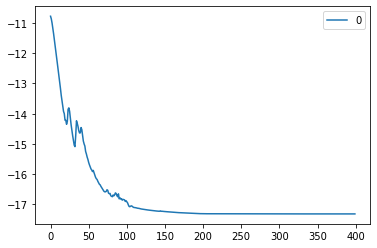

In [30]:
import pandas as pd

loss_plt = pd.DataFrame(train_loss)
loss_plt.plot()

In [33]:
criterion([X1, X2, X3])

tensor(-10.7722, dtype=torch.float64, grad_fn=<NegBackward>)

In [36]:
print(criterion([X1, X1, X1]))
print(criterion([X2, X2, X2]))
print(criterion([X3, X3, X3]))

tensor(-17.3205, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(-17.3205, dtype=torch.float64, grad_fn=<NegBackward>)
tensor(-17.3205, dtype=torch.float64, grad_fn=<NegBackward>)
